In [ ]:
import os
HOME = os.getcwd()

# install fastsam

%cd {HOME}

# install FastSAM
!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
!pip -q install -r FastSAM/requirements.txt
# install CLIP
!pip -q install git+https://github.com/openai/CLIP.git
# install SAM
!pip -q install git+https://github.com/facebookresearch/segment-anything.git

!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
!wget -P {HOME}/weights -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys

np.set_printoptions(threshold=sys.maxsize)

In [2]:
import os
HOME = os.getcwd()

In [3]:
from FastSAM import fastsam

def fast_sam(image_path, output_path):
  model = fastsam.FastSAM(f'{HOME}/weights/FastSAM.pt')

  DEVICE = 'cpu'
  everything_results = model(image_path, device=DEVICE, retina_masks=True, conf=0.4, iou=0.9,)

  prompt_process = fastsam.FastSAMPrompt(image_path, everything_results, device=DEVICE)

  # everything prompt
  # ann = prompt_process.everything_prompt()

  # text prompt
  # ann = prompt_process.text_prompt(text='the two green objects on the sides of the image')
  
  # ann = prompt_process.point_prompt(points=[[620, 360]], pointlabel=[1])
  
  ann = prompt_process.box_prompt(bboxes=[[0, 0, 870, 930], [1100, 0, 2000, 950]])

  prompt_process.plot(annotations=ann, output_path=output_path)

In [4]:
def pixels_to_micrometers(pixels):
    known_pixels = 1920
    known_micrometers = 3659.269
    micrometers = (pixels * known_micrometers) / known_pixels
    return round(micrometers, 2)

In [5]:
def calculate_percentage_error(experimental_value, theoretical_value):
  return round(np.mean(np.abs((theoretical_value - experimental_value) / theoretical_value)) *100, 2)

In [6]:
def brighten(image):
  # convert to LAB and extract L  channel
  LAB = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
  L = LAB[:,:,0]
  # threshold L channel with triangle method
  value, thresh = cv2.threshold(L, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  # threshold with adjusted value
  value = value + 10
  thresh = cv2.threshold(L, value, 255, cv2.THRESH_BINARY)[1]
  # invert threshold and make 3 channels
  thresh = 255 - thresh
  thresh = cv2.merge([thresh, thresh, thresh])
  gain = 2.5
  blue = cv2.multiply(image[:,:,0], gain)
  green = cv2.multiply(image[:,:,1], gain)
  red = cv2.multiply(image[:,:,2], gain)
  img_bright = cv2.merge([blue, green, red])
  # blend original and brightened using thresh as mask
  return np.where(thresh==255, img_bright, image)

In [7]:
def calculate_neck_properties(contour1, contour2):
  # Calculate the pairwise Euclidean distances between all points in the two contours
  distances = np.linalg.norm(contour1[:, None] - contour2, axis=-1)

  # Find the indices of the minimum distance in the distance matrix
  i, j = np.unravel_index(np.argmin(distances), distances.shape)
  
  # Get the nearest points
  nearest_points = (tuple(contour1[i]), tuple(contour2[j]))
  
  left_contour_rightmost_point = nearest_points[0]
  right_contour_leftmost_point = nearest_points[1]
  
  return pixels_to_micrometers(distances[i, j]), left_contour_rightmost_point, right_contour_leftmost_point

In [8]:
def collect_results(index, up_distance, down_distance, left_distance, right_distance, correct_values):
  results = []
  
  down_error = calculate_percentage_error(down_distance, correct_values['down'][index -1])
        
  results.append({'Image': index, 'Type': 'Down', 'Error': f'{down_distance} µm, {down_error} % error' })
  
  right_error = calculate_percentage_error(right_distance, correct_values['right'][index -1])
        
  results.append({'Image': index, 'Type': 'Right', 'Error': f'{right_distance} µm, {right_error} % error' })
  
  left_error = calculate_percentage_error(left_distance, correct_values['left'][index -1])
  
  results.append({'Image': index, 'Type': 'Left', 'Error': f'{left_distance} µm, {left_error} % error' })
  
  up_error = calculate_percentage_error(up_distance, correct_values['up'][index -1])
  
  results.append({'Image': index, 'Type': 'Up', 'Error': f'{up_distance} µm, {up_error} % error' })
  
  return results

In [9]:
def calculate_farthest_points(defects, contour):
    contour_farthest_points = [[0, 0], [0, 0]]
    max_distances = [0, 0]

    if defects is None:
        return contour_farthest_points

    for i in range(defects.shape[0]):
        s, e, f, d = defects[i, 0]
        far = tuple(contour[f])
        distance = d / 256  # Scale the distance
        if distance > max_distances[0]:
            max_distances[1] = max_distances[0]
            contour_farthest_points[1] = contour_farthest_points[0]
            max_distances[0] = distance
            contour_farthest_points[0] = far
        elif distance > max_distances[1]:
            max_distances[1] = distance
            contour_farthest_points[1] = far

    return contour_farthest_points


In [10]:
def create_dir(path):
  exists = os.path.exists(path)
  if not exists:
    os.makedirs(path)

In [11]:
import random as rng
rng.seed(12345)

def process_image(img, index, correct_values, save_path):
    top_crop = 60
    bottom_crop = 70
    left_crop = 60
    right_crop = 60
    
    roi = img[top_crop:-bottom_crop, left_crop:-right_crop]
    
    # roi = brighten(roi)
    
    create_dir(f'images/{save_path}')
    
    PATH = f'./images/{save_path}/{index}.png'
    
    cv2.imwrite(PATH, roi)
    
    create_dir(f'sam_results/{save_path}')
    
    SAM_PATH = f'./sam_results/{save_path}/{index}.png'
    
    fast_sam(PATH, SAM_PATH)
    
    img = cv2.imread(SAM_PATH)
    
    brightened_image = img #brighten(img)

    standard_imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    brightened_imgray = cv2.cvtColor(brightened_image, cv2.COLOR_BGR2GRAY)
    
    _, brightened_thresh = cv2.threshold(
        brightened_imgray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    brightened_contours, hierarchy = cv2.findContours(
        brightened_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    img_with_line = img.copy()
    
    if (len(brightened_contours) < 2):
        cv2.drawContours(img_with_line, brightened_contours, -1, (0, 255, 0), 3)
        create_dir(f'broken/{save_path}')
        plt.imsave(f'./broken/{save_path}/{index}.png', img_with_line)
        print('Less than 2 contours found')
        return None, None
    
    brightened_filtered_contours = sorted(
        brightened_contours, key=lambda x: cv2.contourArea(x), reverse=True)[:2]
    
    brightened_contour1 = np.vstack(brightened_filtered_contours[0])
    brightened_contour2 = np.vstack(brightened_filtered_contours[1])
    
    neck_distance, left_contour_rightmost_point, right_contour_leftmost_point = calculate_neck_properties(brightened_contour1, brightened_contour2)
    
    results = []
        
    neck_error = calculate_percentage_error(neck_distance, correct_values['neck'][index -1])
        
    results.append({'Image': index, 'Type': 'Neck', 'Error': f'{neck_distance} µm, {neck_error} % error' })
    
    hull1 = cv2.convexHull(brightened_contour1, returnPoints=False)
    hull2 = cv2.convexHull(brightened_contour2, returnPoints=False)

    cv2.drawContours(img_with_line, brightened_filtered_contours, -1, (0, 255, 0), 3)
    
    hull_list = []
    for i in range(len(brightened_filtered_contours)):
        hull = cv2.convexHull(brightened_filtered_contours[i])
        hull_list.append(hull)

    defects1 = cv2.convexityDefects(brightened_contour1, hull1)
    defects2 = cv2.convexityDefects(brightened_contour2, hull2)
    
    contour1_farthest_points = calculate_farthest_points(defects1, brightened_contour1)
    contour2_farthest_points = calculate_farthest_points(defects2, brightened_contour2)
    
    contour1_start, contour1_end = np.array(contour1_farthest_points[0]), np.array(contour1_farthest_points[1])
    contour2_start, contour2_end = np.array(contour2_farthest_points[0]), np.array(contour2_farthest_points[1])
    
    if contour1_start[1] < contour1_end[1]:
        contour1_start, contour1_end = contour1_end, contour1_start
    
    if contour2_start[1] < contour2_end[1]:
        contour2_start, contour2_end = contour2_end, contour2_start
    
    down_distance = pixels_to_micrometers(
        np.linalg.norm(contour1_end - contour2_end))
    
    up_distance = pixels_to_micrometers(
        np.linalg.norm(contour1_start - contour2_start))
    
    left_distance = pixels_to_micrometers(
        np.linalg.norm(contour1_start - contour1_end))

    right_distance = pixels_to_micrometers(
        np.linalg.norm(contour2_start - contour2_end))
    
    results += collect_results(index, down_distance, up_distance, left_distance, right_distance, correct_values)

    cv2.line(img_with_line, contour1_start, contour2_start, (255, 0, 0), 2)

    cv2.line(img_with_line, contour1_end, contour2_end, (255, 0, 0), 2)

    cv2.line(img_with_line, contour1_start, contour1_end, (255, 0, 0), 2)

    cv2.line(img_with_line, contour2_start, contour2_end, (255, 0, 0), 2)

    cv2.line(img_with_line, left_contour_rightmost_point, right_contour_leftmost_point, (0, 0, 255), 2)

    return img_with_line, results


In [12]:
def extract_sequence_name_from_path(path: str):
  return path.split('/')[1].split('.')[0]

In [13]:
def process_sequence(path, correct_values, output_file):
    loaded, imgs = cv2.imreadmulti(path)
    processed_images = []
    num_images = len(imgs)
    all_results = []

    for i, img in enumerate(imgs):
        img_with_line, results = process_image(imgs[i], i + 1, correct_values, extract_sequence_name_from_path(path))
        
        if results is not None: all_results.extend(results)
        if img_with_line is not None: processed_images.append(img_with_line)    
    
    return all_results, processed_images

In [14]:
from correct_values.correct_0_percent import CORRECT_0_PERCENT_NECK, CORRECT_0_PERCENT_LEFT, CORRECT_0_PERCENT_RIGHT, CORRECT_0_PERCENT_UP, CORRECT_0_PERCENT_DOWN
from correct_values.correct_3_percent import CORRECT_3_PERCENT_NECK, CORRECT_3_PERCENT_LEFT, CORRECT_3_PERCENT_RIGHT, CORRECT_3_PERCENT_UP, CORRECT_3_PERCENT_DOWN
from correct_values.correct_5_percent import CORRECT_5_PERCENT_NECK, CORRECT_5_PERCENT_LEFT, CORRECT_5_PERCENT_RIGHT, CORRECT_5_PERCENT_UP, CORRECT_5_PERCENT_DOWN
from correct_values.correct_15_percent import CORRECT_15_PERCENT_NECK, CORRECT_15_PERCENT_LEFT, CORRECT_15_PERCENT_RIGHT, CORRECT_15_PERCENT_UP, CORRECT_15_PERCENT_DOWN
from correct_values.correct_16_percent import CORRECT_16_PERCENT_NECK, CORRECT_16_PERCENT_LEFT, CORRECT_16_PERCENT_RIGHT, CORRECT_16_PERCENT_UP, CORRECT_16_PERCENT_DOWN
from correct_values.correct_20_percent import CORRECT_20_PERCENT_NECK, CORRECT_20_PERCENT_LEFT, CORRECT_20_PERCENT_RIGHT, CORRECT_20_PERCENT_UP, CORRECT_20_PERCENT_DOWN

In [15]:

IMAGES_DATA = [
    {
        'path': 'data/20%.tif',
        'values': {
            'right': CORRECT_20_PERCENT_RIGHT,
            'left': CORRECT_20_PERCENT_LEFT,
            'up': CORRECT_20_PERCENT_UP,
            'down': CORRECT_20_PERCENT_DOWN,
            'neck': CORRECT_20_PERCENT_NECK,
        }
    },
    {
        'path': 'data/16%.tif',
        'values': {
            'right': CORRECT_16_PERCENT_RIGHT,
            'left': CORRECT_16_PERCENT_LEFT,
            'up': CORRECT_16_PERCENT_UP,
            'down': CORRECT_16_PERCENT_DOWN,
            'neck': CORRECT_16_PERCENT_NECK,
        }
    },
    {
        'path': 'data/15%.tif',
        'values': {
            'right': CORRECT_15_PERCENT_RIGHT,
            'left': CORRECT_15_PERCENT_LEFT,
            'up': CORRECT_15_PERCENT_UP,
            'down': CORRECT_15_PERCENT_DOWN,
            'neck': CORRECT_15_PERCENT_NECK,
        }
    },
    {
        'path': 'data/5%.tif',
        'values': {
            'right': CORRECT_5_PERCENT_RIGHT,
            'left': CORRECT_5_PERCENT_LEFT,
            'up': CORRECT_5_PERCENT_UP,
            'down': CORRECT_5_PERCENT_DOWN,
            'neck': CORRECT_5_PERCENT_NECK,
        }
    },
    {
        'path': 'data/3%.tif',
        'values': {
            'right': CORRECT_3_PERCENT_RIGHT,
            'left': CORRECT_3_PERCENT_LEFT,
            'up': CORRECT_3_PERCENT_UP,
            'down': CORRECT_3_PERCENT_DOWN,
            'neck': CORRECT_3_PERCENT_NECK,
        }
    },
        {
        'path': 'data/0%.tif',
        'values': {
            'right': CORRECT_0_PERCENT_RIGHT,
            'left': CORRECT_0_PERCENT_LEFT,
            'up': CORRECT_0_PERCENT_UP,
            'down': CORRECT_0_PERCENT_DOWN,
            'neck': CORRECT_0_PERCENT_NECK,
        }
    }
]


In [16]:
sequences_results = []
all_processed_images = []

for i in range(len(IMAGES_DATA)):
    image_data = IMAGES_DATA[i]
    sequence_results, processed_images = process_sequence(image_data['path'], image_data['values'], f'results/{image_data["path"].split("/")[1]}')
    sequences_results.append(sequence_results)
    all_processed_images.append(processed_images)


image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\20%\1.png: 544x1024 2 objects, 1513.4ms
Speed: 3.0ms preprocess, 1513.4ms inference, 17.7ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\20%\2.png: 544x1024 3 objects, 1632.2ms
Speed: 2.0ms preprocess, 1632.2ms inference, 25.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\20%\3.png: 544x1024 2 objects, 1723.1ms
Speed: 3.0ms preprocess, 1723.1ms inference, 27.5ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\20%\4.png: 544x1024 2 objects, 2285.2ms
Speed: 5.0ms preprocess, 2285.2ms inference, 27.4ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\20%\5.png: 544x1024 2 objects, 2615.3ms
Speed: 6.0ms

Less than 2 contours found



image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\15%\2.png: 544x1024 1 object, 5310.4ms
Speed: 8.0ms preprocess, 5310.4ms inference, 29.6ms postprocess per image at shape (1, 3, 1024, 1024)


Less than 2 contours found



image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\15%\3.png: 544x1024 2 objects, 4125.3ms
Speed: 13.2ms preprocess, 4125.3ms inference, 45.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\15%\4.png: 544x1024 2 objects, 3505.3ms
Speed: 6.0ms preprocess, 3505.3ms inference, 54.6ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\15%\5.png: 544x1024 2 objects, 3714.9ms
Speed: 7.0ms preprocess, 3714.9ms inference, 45.1ms postprocess per image at shape (1, 3, 1024, 1024)


Less than 2 contours found



image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\15%\6.png: 544x1024 1 object, 3435.8ms
Speed: 7.1ms preprocess, 3435.8ms inference, 15.0ms postprocess per image at shape (1, 3, 1024, 1024)


Less than 2 contours found



image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\15%\7.png: 544x1024 1 object, 3074.7ms
Speed: 7.0ms preprocess, 3074.7ms inference, 16.0ms postprocess per image at shape (1, 3, 1024, 1024)


Less than 2 contours found



image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\5%\1.png: 544x1024 3 objects, 3013.3ms
Speed: 5.0ms preprocess, 3013.3ms inference, 49.2ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\5%\2.png: 544x1024 3 objects, 3032.8ms
Speed: 5.0ms preprocess, 3032.8ms inference, 51.3ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\5%\3.png: 544x1024 3 objects, 3613.4ms
Speed: 7.8ms preprocess, 3613.4ms inference, 111.5ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\5%\4.png: 544x1024 4 objects, 3801.7ms
Speed: 7.7ms preprocess, 3801.7ms inference, 76.5ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\5%\5.png: 544x1024 2 objects, 3581.6ms
Speed: 7.0ms pre

Less than 2 contours found



image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\3%\11.png: 544x1024 3 objects, 3701.5ms
Speed: 7.9ms preprocess, 3701.5ms inference, 55.5ms postprocess per image at shape (1, 3, 1024, 1024)


Less than 2 contours found



image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\0%\1.png: 544x1024 2 objects, 4250.9ms
Speed: 9.0ms preprocess, 4250.9ms inference, 38.6ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\0%\2.png: 544x1024 2 objects, 3901.1ms
Speed: 7.6ms preprocess, 3901.1ms inference, 44.3ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\0%\3.png: 544x1024 2 objects, 3675.9ms
Speed: 9.0ms preprocess, 3675.9ms inference, 42.8ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\0%\4.png: 544x1024 2 objects, 3699.5ms
Speed: 6.0ms preprocess, 3699.5ms inference, 38.6ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\ppetko\projects\capillary-bridges-image-analysis\images\0%\5.png: 544x1024 2 objects, 3383.0ms
Speed: 8.0ms prep

In [17]:
import pandas as pd

tables = []

for result in sequences_results:
  df = pd.DataFrame(result)

  table = df.pivot(index='Image', columns='Type', values='Error')
  tables.append(table)

In [18]:
from IPython.display import display_html

df1_styler = tables[0].style.set_table_attributes(
    "style='display:inline'").set_caption('20%')
df2_styler = tables[1].style.set_table_attributes(
    "style='display:inline'").set_caption('16%')
df3_styler = tables[2].style.set_table_attributes(
    "style='display:inline'").set_caption('15%')
df4_styler = tables[3].style.set_table_attributes(
    "style='display:inline'").set_caption('5%')
df5_styler = tables[4].style.set_table_attributes(
    "style='display:inline'").set_caption('3%')
df6_styler = tables[5].style.set_table_attributes(
    "style='display:inline'").set_caption('0%')

display_html(df1_styler._repr_html_() + df2_styler._repr_html_() + df3_styler._repr_html_() +
             df4_styler._repr_html_() + df5_styler._repr_html_() + df6_styler._repr_html_(), raw=True)


20% 
 
 
 Type 
 Down 
 Left 
 Neck 
 Right 
 Up 
 
 
 Image 
   
   
   
   
   
 
 
 
 
 1 
 1781.49 µm, 47.24 % error 
 439.28 µm, 35.94 % error 
 1749.85 µm, 37.78 % error 
 219.67 µm, 69.11 % error 
 2300.52 µm, 29.16 % error 
 
 
 2 
 2186.39 µm, 32.39 % error 
 486.84 µm, 43.63 % error 
 1620.48 µm, 37.39 % error 
 316.33 µm, 61.89 % error 
 2288.63 µm, 26.67 % error 
 
 
 3 
 1646.59 µm, 49.78 % error 
 582.41 µm, 43.86 % error 
 1425.59 µm, 37.7 % error 
 629.81 µm, 39.0 % error 
 2113.61 µm, 26.65 % error 
 
 
 4 
 1619.5 µm, 47.97 % error 
 500.51 µm, 57.27 % error 
 1265.78 µm, 39.8 % error 
 751.38 µm, 36.92 % error 
 2062.15 µm, 27.3 % error 
 
 
 5 
 1895.4 µm, 41.52 % error 
 386.99 µm, 72.92 % error 
 1138.0 µm, 38.13 % error 
 852.63 µm, 38.32 % error 
 2007.28 µm, 27.53 % error 
 
 
 6 
 2090.12 µm, 39.43 % error 
 415.36 µm, 75.26 % error 
 937.88 µm, 37.28 % error 
 1018.78 µm, 39.09 % error 
 2024.21 µm, 26.11 % error 
 
 
 7 
 2173.86 µm, 45.13 % error 
 542.61 µm, 70.45 % error 
 764.25 µm, 36.76 % error 
 1109.75 µm, 37.6 % error 
 2155.61 µm, 15.32 % error 
 
 
 

 
 16% 
 
 
 Type 
 Down 
 Left 
 Neck 
 Right 
 Up 
 
 
 Image 
   
   
   
   
   
 
 
 
 
 1 
 1600.29 µm, 5.69 % error 
 358.38 µm, 6.68 % error 
 1500.0 µm, 0.09 % error 
 420.66 µm, 25.24 % error 
 1935.63 µm, 23.62 % error 
 
 
 2 
 996.07 µm, 33.34 % error 
 987.24 µm, 111.91 % error 
 10.26 µm, 99.24 % error 
 843.11 µm, 89.19 % error 
 1030.34 µm, 30.31 % error 
 
 
 3 
 2834.05 µm, 99.6 % error 
 798.62 µm, 53.09 % error 
 1395.32 µm, 13.22 % error 
 323.04 µm, 37.32 % error 
 1910.8 µm, 38.32 % error 
 
 
 4 
 661.41 µm, 48.78 % error 
 657.55 µm, 2.06 % error 
 464.99 µm, 56.64 % error 
 26.95 µm, 95.88 % error 
 708.02 µm, 45.33 % error 
 
 
 5 
 1231.34 µm, 0.06 % error 
 779.61 µm, 1.86 % error 
 980.29 µm, 0.44 % error 
 766.62 µm, 2.37 % error 
 1244.55 µm, 1.58 % error 
 
 
 6 
 1193.2 µm, 1.59 % error 
 955.68 µm, 0.63 % error 
 860.09 µm, 2.62 % error 
 932.41 µm, 1.34 % error 
 1181.65 µm, 0.73 % error 
 
 
 7 
 1695.81 µm, 44.38 % error 
 1156.57 µm, 1.6 % error 
 1341.07 µm, 86.44 % error 
 89.58 µm, 91.99 % error 
 1883.73 µm, 62.73 % error 
 
 
 8 
 1834.24 µm, 56.16 % error 
 1345.49 µm, 1.12 % error 
 559.15 µm, 1.72 % error 
 1633.05 µm, 23.04 % error 
 1134.05 µm, 2.03 % error 
 
 
 9 
 1225.57 µm, 4.02 % error 
 1431.05 µm, 2.25 % error 
 392.65 µm, 3.73 % error 
 429.24 µm, 70.48 % error 
 2132.3 µm, 84.2 % error 
 
 
 

 
 15% 
 
 
 Type 
 Down 
 Left 
 Neck 
 Right 
 Up 
 
 
 Image 
   
   
   
   
   
 
 
 
 
 3 
 1200.86 µm, 46.6 % error 
 372.25 µm, 37.63 % error 
 1099.69 µm, 40.46 % error 
 346.89 µm, 40.77 % error 
 1260.75 µm, 43.09 % error 
 
 
 4 
 1207.43 µm, 44.91 % error 
 464.4 µm, 31.81 % error 
 1010.23 µm, 37.19 % error 
 439.69 µm, 38.8 % error 
 1206.67 µm, 43.56 % error 
 
 
 

 
 5% 
 
 
 Type 
 Down 
 Left 
 Neck 
 Right 
 Up 
 
 
 Image 
   
   
   
   
   
 
 
 
 
 1 
 1458.11 µm, 0.72 % error 
 421.35 µm, 1.89 % error 
 1429.58 µm, 1.09 % error 
 408.14 µm, 1.49 % error 
 1484.68 µm, 0.85 % error 
 
 
 2 
 2807.73 µm, 92.78 % error 
 447.9 µm, 9.69 % error 
 2302.47 µm, 76.09 % error 
 0.0 µm, 100.0 % error 
 2589.47 µm, 79.3 % error 
 
 
 3 
 1353.33 µm, 2.35 % error 
 564.86 µm, 3.05 % error 
 1215.95 µm, 0.04 % error 
 541.35 µm, 3.71 % error 
 1372.23 µm, 0.26 % error 
 
 
 4 
 1303.7 µm, 0.11 % error 
 619.45 µm, 5.62 % error 
 1131.18 µm, 0.48 % error 
 641.4 µm, 3.74 % error 
 1332.21 µm, 0.13 % error 
 
 
 5 
 1218.07 µm, 0.69 % error 
 732.66 µm, 1.17 % error 
 1027.26 µm, 1.8 % error 
 753.44 µm, 0.46 % error 
 1282.65 µm, 0.59 % error 
 
 
 6 
 1177.95 µm, 1.16 % error 
 857.06 µm, 3.38 % error 
 924.21 µm, 0.17 % error 
 871.99 µm, 3.31 % error 
 1267.4 µm, 0.6 % error 
 
 
 7 
 1160.71 µm, 0.4 % error 
 963.38 µm, 1.7 % error 
 806.19 µm, 3.31 % error 
 976.34 µm, 3.5 % error 
 1235.01 µm, 0.24 % error 
 
 
 8 
 1143.54 µm, 1.08 % error 
 1125.17 µm, 0.6 % error 
 726.23 

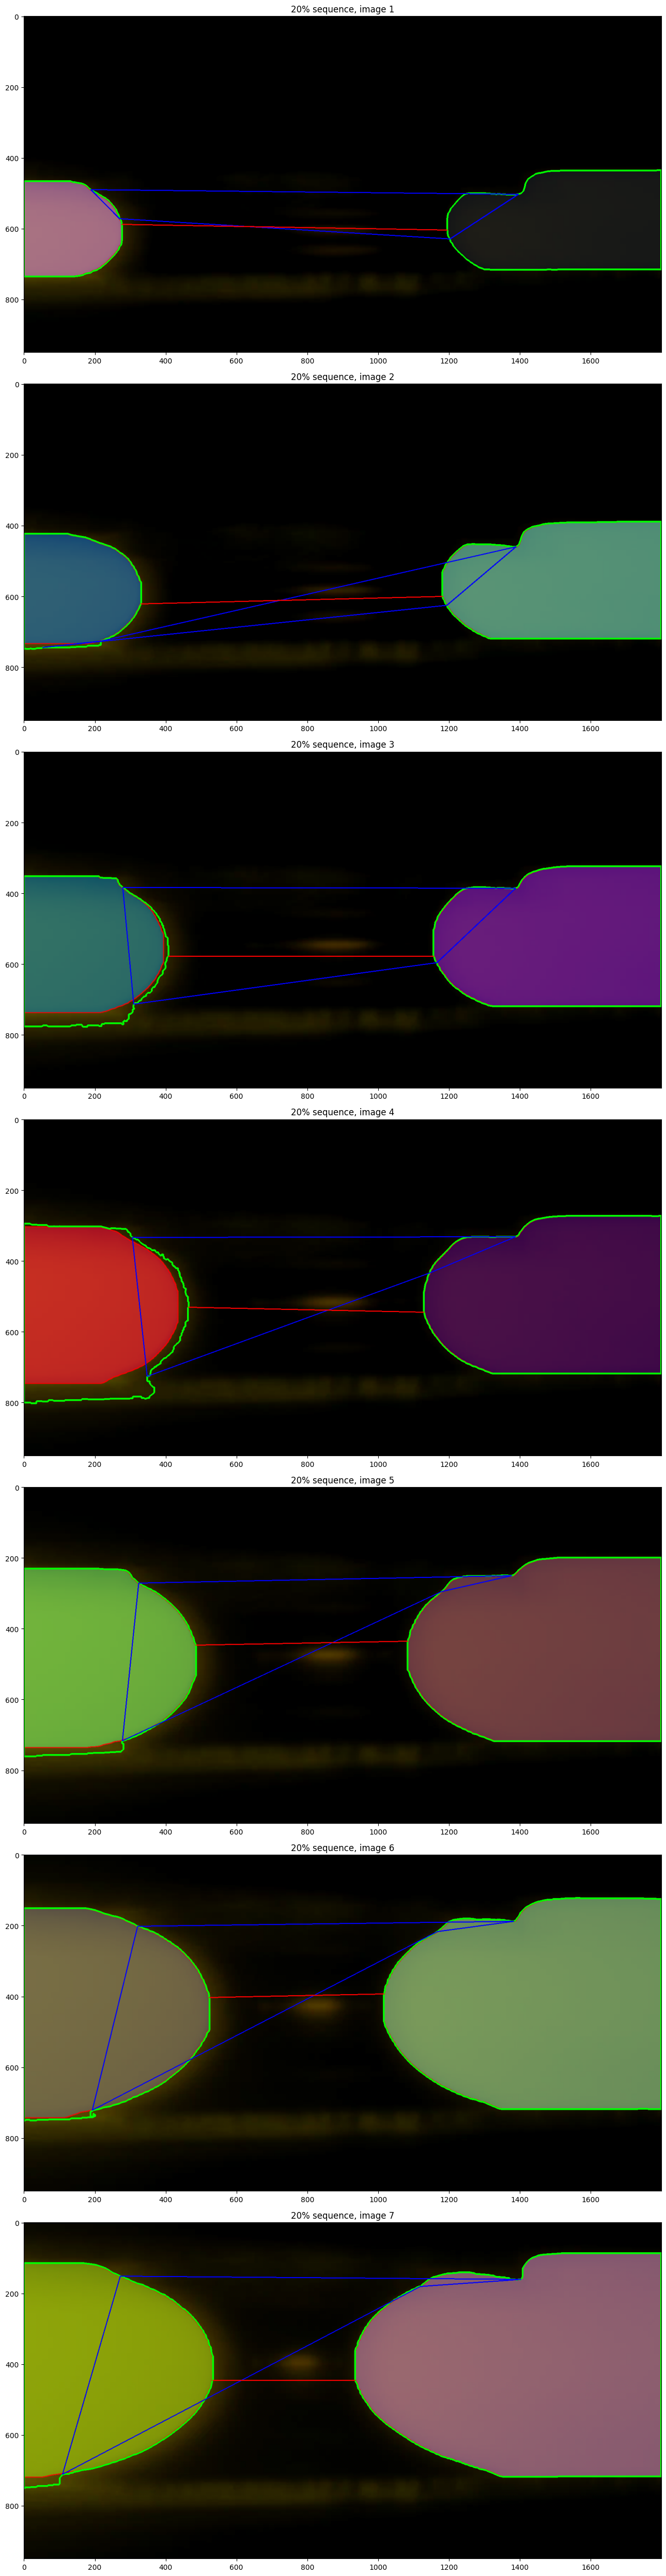

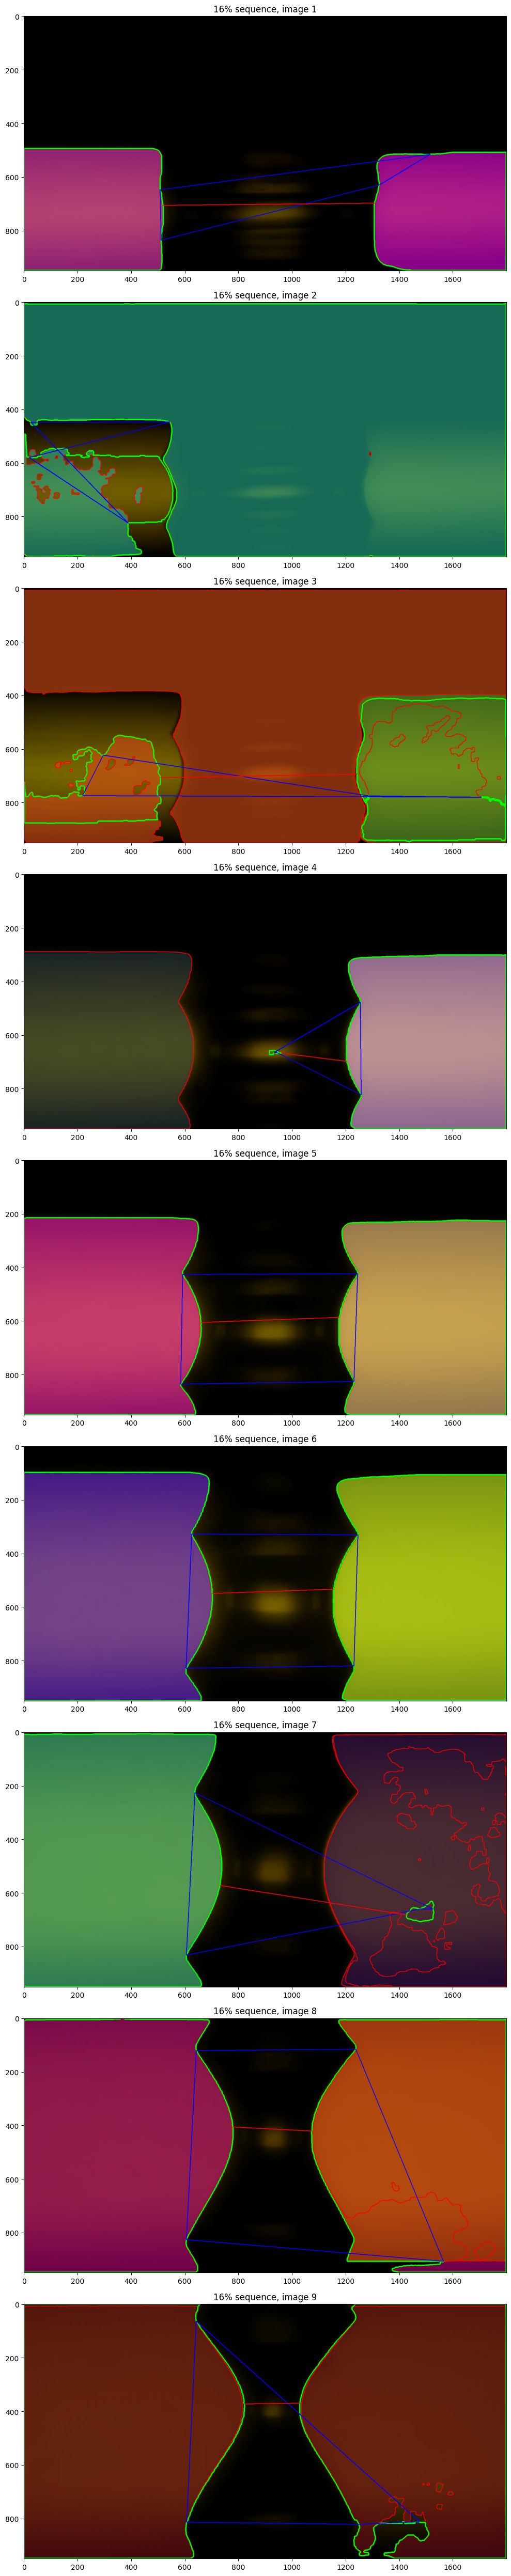

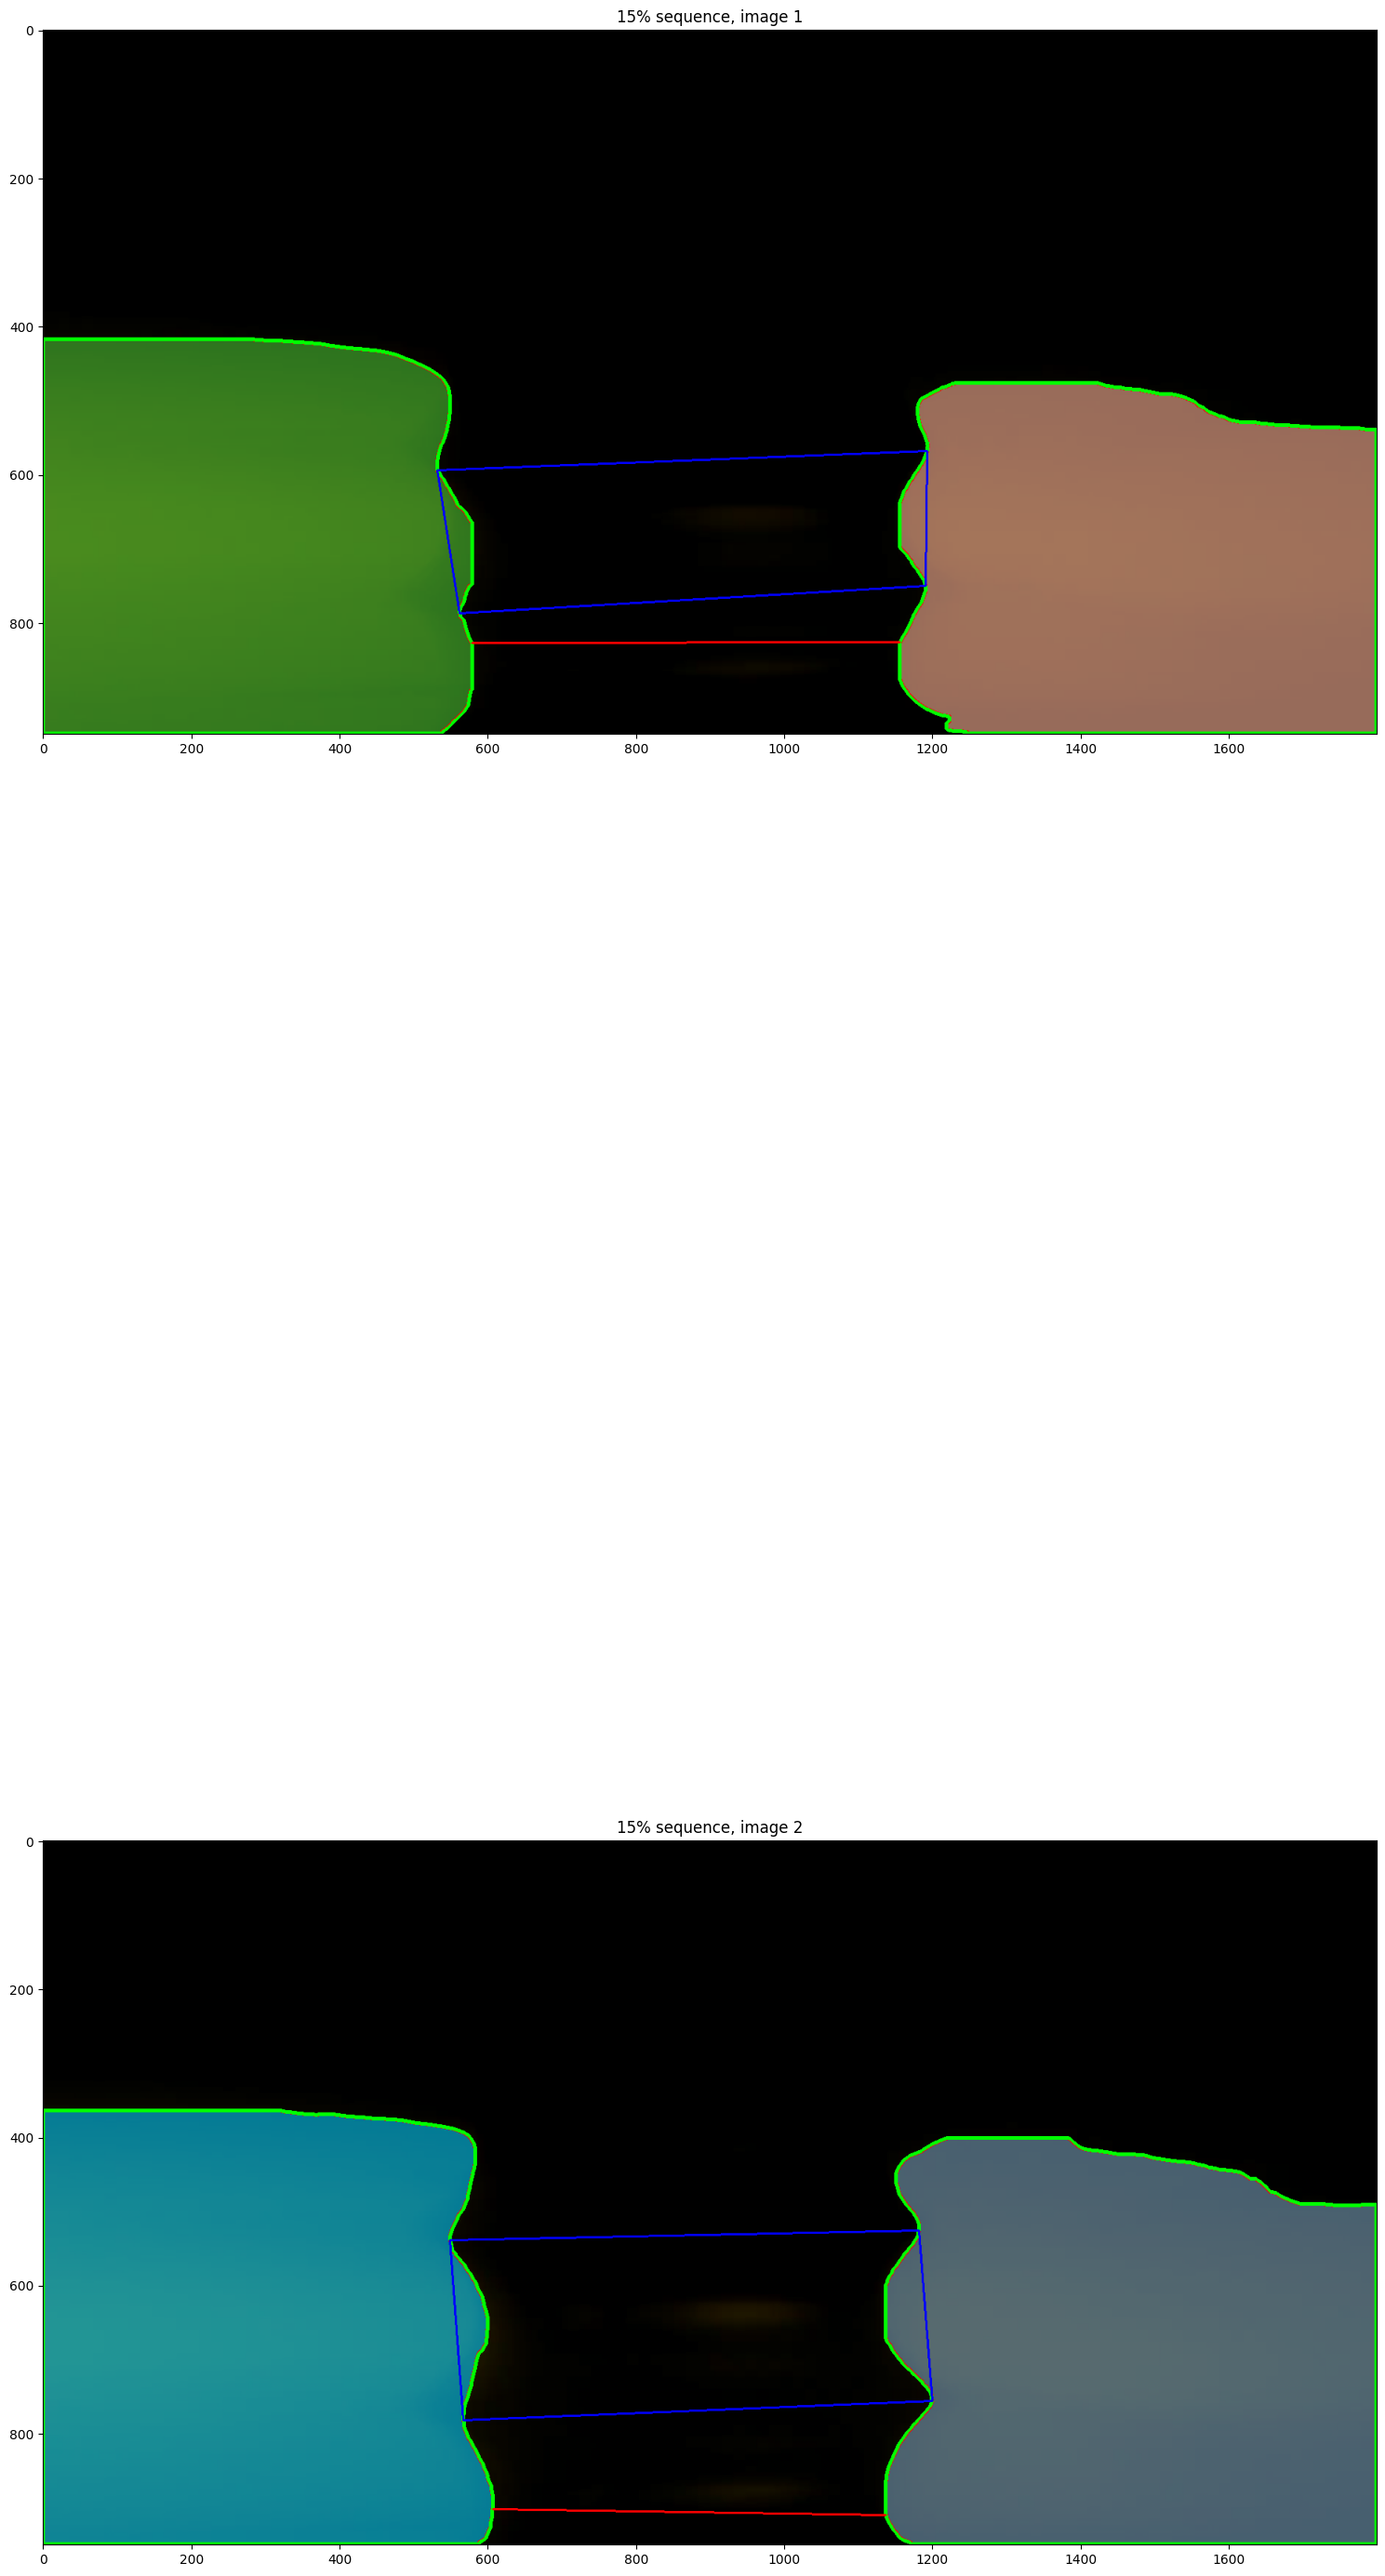

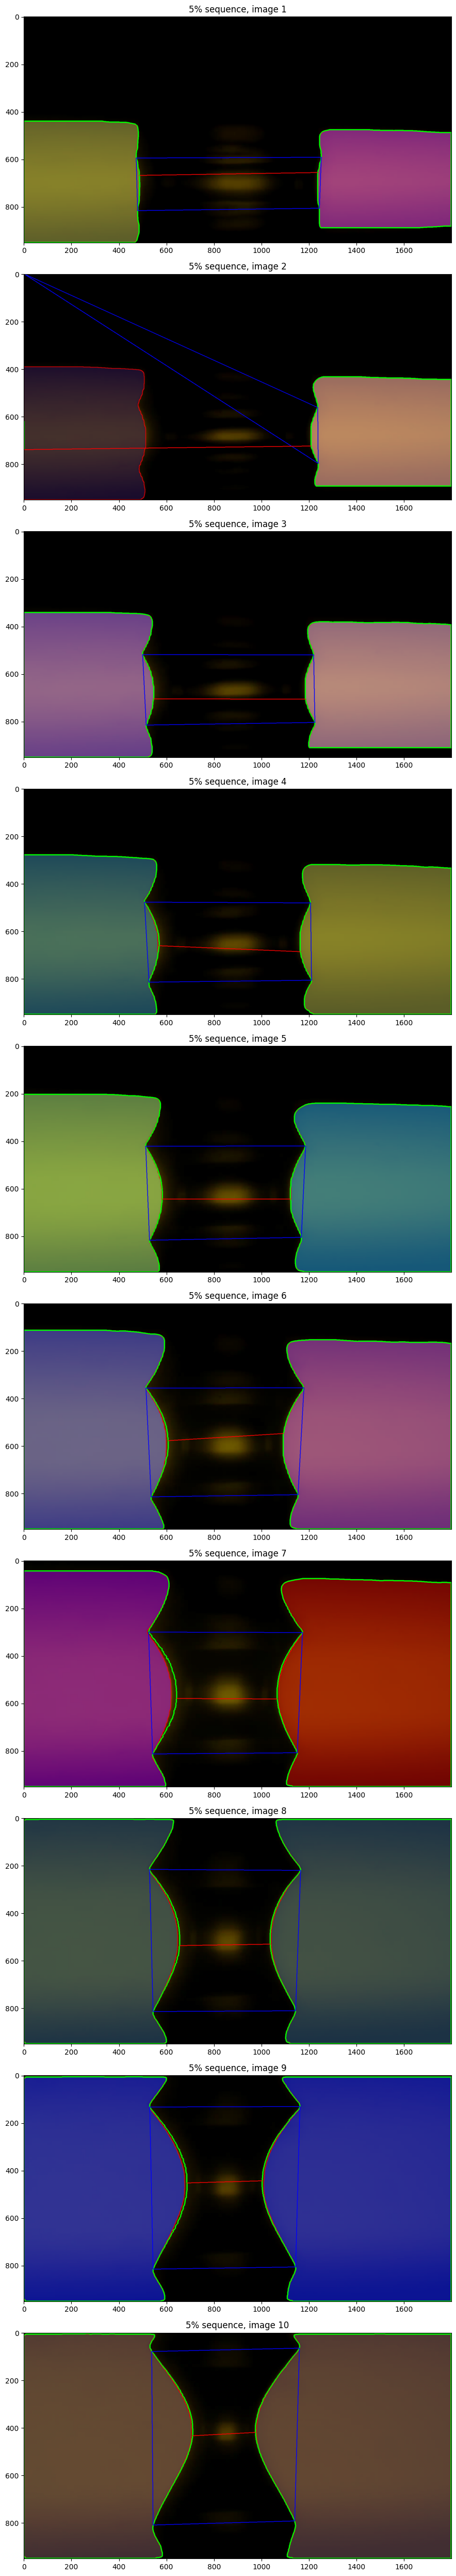

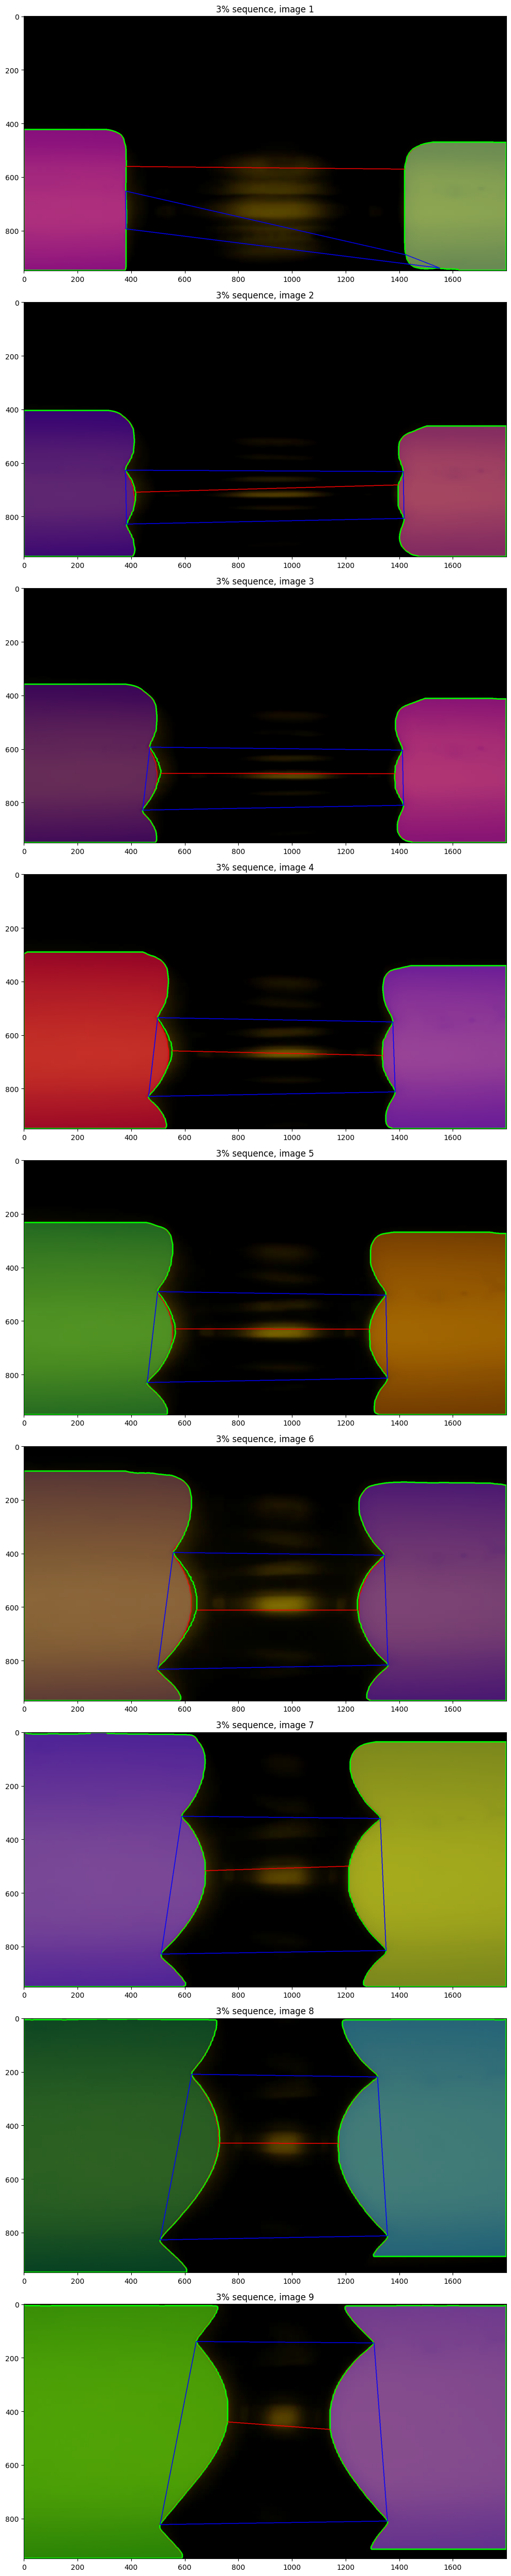

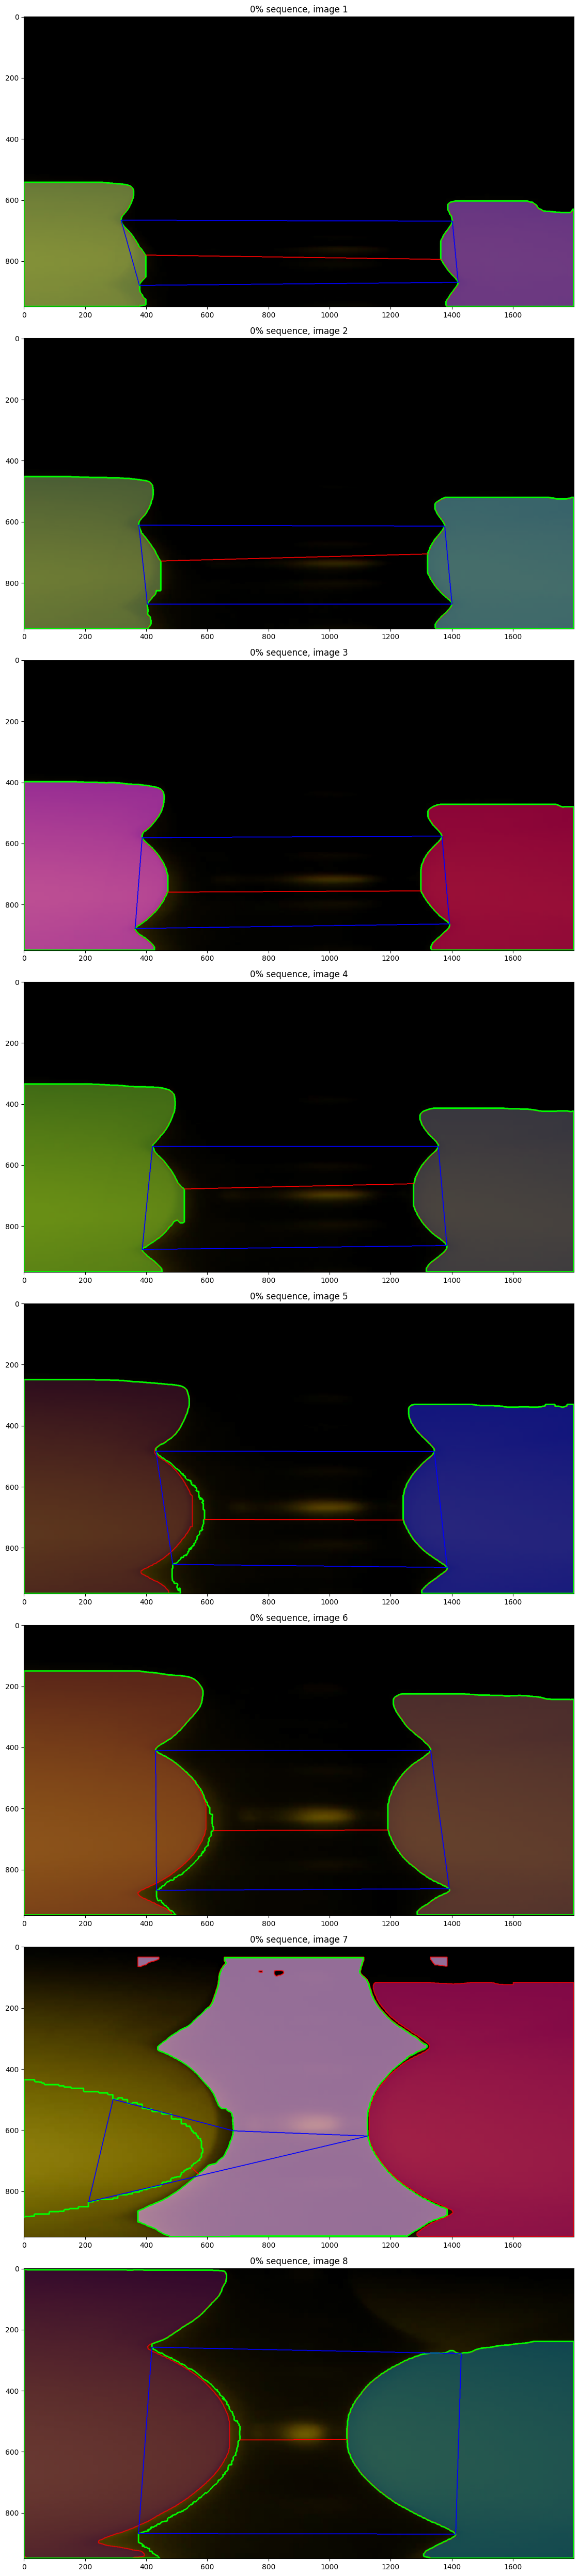

In [19]:
INDEX_TO_SEQUENCE = {
    0: '20%',
    1: '16%',
    2: '15%',
    3: '5%',
    4: '3%',
    5: '0%',
}

for i, image_sequence in enumerate(all_processed_images):
    create_dir(f'./final_results/{INDEX_TO_SEQUENCE[i]}')
    
    plt.figure(figsize=(15, 50))
    
    SEQ = INDEX_TO_SEQUENCE[i]
    
    for j, image in enumerate(image_sequence):
        plt.subplot(len(image_sequence), 1, j + 1)
        plt.imshow(cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB))
        plt.title(f'{SEQ} sequence, image {j + 1}')
        cv2.imwrite(f'./final_results/{SEQ}/{j}.png', image)

    plt.tight_layout()

In [ ]:
import cv2

def access_webcam():
    cap = cv2.VideoCapture(0)  # Try using a different camera index (e.g., 1, 2, etc.)

    while True:
        ret, frame = cap.read()
        print('frame: ', frame)
        cv2.imshow('Webcam Feed', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

access_webcam()